In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df read_montage(fname):
    chs = []
    x = []
    y = []
    z = []
    with open(fname, "r") as f:
        for line in f:
            parts = line.split("\t")
            if parts[0][0] == "E":
                channel_number = int(parts[0][1:])
                chs.append(channel_number)
                x.append(float(parts[1]))
                y.append(float(parts[2]))
                z.append(float(parts[3]))

    x = np.array([x, y, z])
    
    return x, chs

def cartesian_to_spherical(montage_xyz):
    montage_spher = np.zeros(montage_xyz.shape)
    xy = np.sum(np.power(montage_xyz[0:2], 2), axis=0)
    montage_spher[0] = np.sqrt(xy + np.power(montage_xyz[2], 2))              # r
    montage_spher[1] = np.arctan2(np.sqrt(xy), montage_xyz[2])      # theta
    montage_spher[2] = np.arctan2(montage_xyz[1], montage_xyz[0])   # phi

    return montage_spher

def spherical_to_cartesian(montage_spher):
    montage_approx = np.zeros((2, montage_spher.shape[1]))
    montage_approx[0] = montage_spher[1] * np.cos(montage_spher[2])
    montage_approx[1] = montage_spher[1] * np.sin(montage_spher[2])
    return montage_approx

def spherical_to_cartesian_squish(montage_spher):
    montage_approx = np.zeros((2, montage_spher.shape[1]))
    scale_angle = np.power(np.sin(montage_spher[2] * 2) * np.sin(montage_spher[2] * 2), 4) + 2
    montage_approx[0] = np.power(montage_spher[1], 0.8) * np.cos(montage_spher[2]) * scale_angle
    montage_approx[1] = np.power(montage_spher[1], 0.8) * np.sin(montage_spher[2]) * scale_angle
    return montage_approx

def montage_to_2d(montage):
    montage_spher = cartesian_to_spherical(montage)
    return spherical_to_cartesian(montage_spher)


In [50]:
MONTAGE_FNAME = "GSN-HydroCel-128.sfp"

montage, chs = read_montage(MONTAGE_FNAME)
print(montage.shape)

(3, 128)


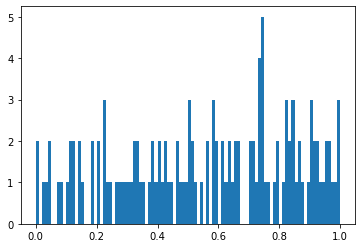

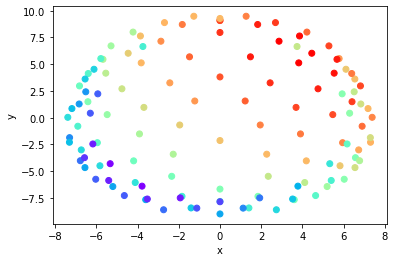

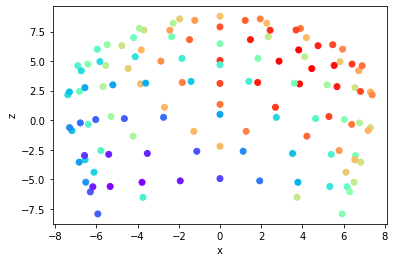

In [51]:
pos1d = np.sum(montage, axis=0)
pos1d = pos1d - np.amin(pos1d)
pos1d = pos1d / np.amax(pos1d)
colors = cm.rainbow(pos1d)

plt.figure()
plt.hist(pos1d, bins=100)

plt.figure()
plt.scatter(montage[0], montage[1], c = colors)
plt.xlabel("x")
plt.ylabel("y")

plt.figure()
plt.scatter(montage[0], montage[2], c = colors)
plt.xlabel("x")
plt.ylabel("z")

plt.show()

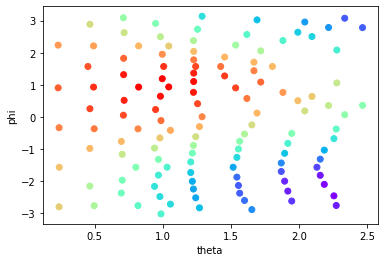

In [52]:
montage_spher = cartesian_to_spherical(montage)

plt.figure()
plt.scatter(montage_spher[1], montage_spher[2], c = colors)
plt.xlabel("theta")
plt.ylabel("phi")

plt.show()

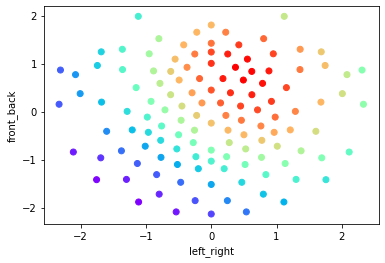

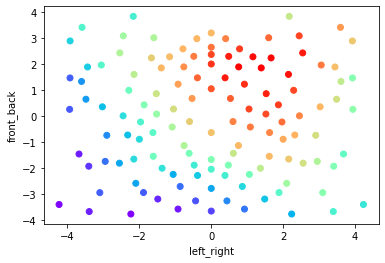

In [87]:
montage2d = spherical_to_cartesian(montage_spher)

plt.figure()
plt.scatter(montage2d[0], montage2d[1], c = colors)
plt.xlabel("left_right")
plt.ylabel("front_back")

montage2d_squish = spherical_to_cartesian_squish(montage_spher)

plt.figure()
plt.scatter(montage2d_squish[0], montage2d_squish[1], c = colors)
plt.xlabel("left_right")
plt.ylabel("front_back")

plt.show()

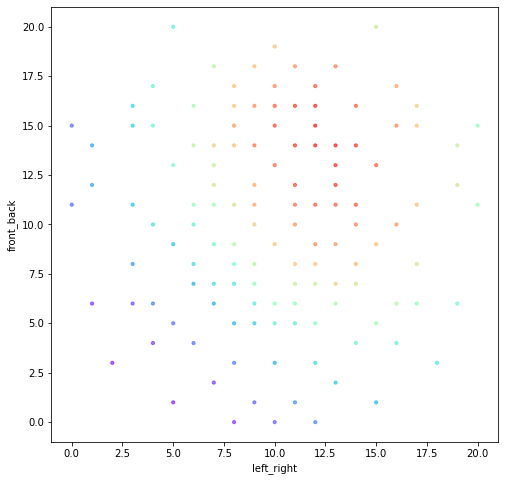

In [97]:
N_X = 20
N_Y = 20
grid_size = np.array([N_X, N_Y])
montage2d_bin = (montage2d.T - np.amin(montage2d, axis=1)).T
montage2d_bin = np.round((montage2d_bin.T / np.amax(montage2d_bin, axis=1) * grid_size).T).astype(int)

plt.figure(figsize=(8,8))
plt.scatter(montage2d_bin[0], montage2d_bin[1], c = colors, s=10, alpha=0.6)
plt.xlabel("left_right")
plt.ylabel("front_back")

plt.show()

127


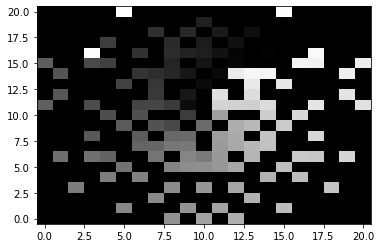

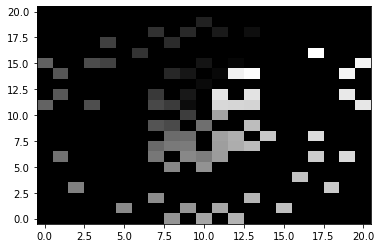

In [104]:
im = np.zeros((N_X+1, N_Y+1), dtype=int)
im_special = np.zeros((N_X+1, N_Y+1), dtype=int)

x_range = np.linspace(0, N_X, N_X+1, dtype=int)
y_range = np.linspace(0, N_Y, N_Y+1, dtype=int)
ch_special = (np.array([66, 67, 71, 72, 73, 76, 77, 78, 84, 85]) - 1).tolist()
include = ['E3', 'E4', 'E5', 'E6', 'E7', 'E10', 'E11', 'E12', 'E13', 'E16', 'E19', 'E20', 'E21', 'E24', 'E25', 'E28', 'E29', 'E30', 'E31', 'E32', 'E35', 'E36', 'E37', 'E38', 'E41', 'E42', 'E43', 'E47', 'E48', 'E51', 'E52', 'E53', 'E54', 'E55', 'E58', 'E59', 'E60', 'E61', 'E62', 'E65', 'E66', 'E67', 'E68', 'E71', 'E72', 'E73', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E84', 'E85', 'E87', 'E88', 'E91', 'E92', 'E93', 'E94', 'E97', 'E98', 'E99', 'E103', 'E104', 'E105', 'E106', 'E107', 'E110', 'E111', 'E112', 'E113', 'E117', 'E118', 'E119', 'E123', 'E124']
tmp = [include[i][1:] for i in range(len(include))]
ch_special = [int(tmp[i]) for i in range(len(tmp))]


chs = np.array(chs)

for i in x_range:
    for j in y_range:
        ind_x = montage2d_bin[0] == i
        ind_y = montage2d_bin[1] == j
        equal = np.logical_and(ind_x, ind_y)
        if np.sum(equal) > 1:
            print(f"Warning: several electrodes at (x,y)= ({i}, {j})")
        if np.any(equal):
            ch = np.nonzero(equal)[0]
            if ch in ch_special:
                im_special[i,j] = ch
            im[i,j] = ch

im_bool = im > 0
print(np.sum(im_bool))
plt.figure()
plt.pcolormesh(x_range, y_range, im.T, cmap="gray")
plt.figure()
plt.pcolormesh(x_range, y_range, im_special.T, cmap="gray")
plt.show()

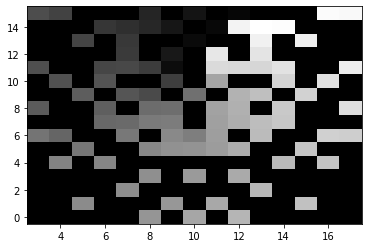

In [103]:
"""
    Just select occipital?
"""

X_LOW = 7
X_HIGH = 14

Y_LOW = 5
Y_HIGH = 10

X_LOW = 3
X_HIGH = 18

Y_LOW = 0
Y_HIGH = 16

im_cropped = (im[X_LOW:X_HIGH])[:,Y_LOW:Y_HIGH]

plt.figure()
plt.pcolormesh(x_range[X_LOW:X_HIGH], y_range[Y_LOW:Y_HIGH], im_cropped.T, cmap="gray")
plt.show()

In [29]:
def transform_2d_to_3d(x2d, montage, nx, ny):
    assert(montage.shape[1] == x.shape[0]) # Number of channels match
    x3d = np.zeros((nx, ny, x2d.shape[1]))

    montage_2d = montage_to_2d(montage)
    grid_size = np.array([nx, ny])
    montage2d_bin = (montage2d.T - np.amin(montage2d, axis=1)).T
    montage2d_bin = np.round((montage2d_bin.T / np.amax(montage2d_bin, axis=1) * grid_size).T).astype(int)

    for i in range(nx+1):
        for j in range(ny+1):
            ind_x = montage2d_bin[0] == i
            ind_y = montage2d_bin[1] == j
            equal = np.logical_and(ind_x, ind_y)
            if np.sum(equal) > 1:
                raise Exception(f"Error: several electrodes at (x,y)= ({i}, {j})")

            if np.any(equal):
                x3d[i,j] = x[np.nonzero(equal)[0]]

    return x3d
